# Recurrent Neural Networks
You should build an end-to-end machine learning pipeline using a recurrent neural network model. In particular, you should do the following:
- Load the `jena climate` dataset using [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). You can find this dataset in the [keras repository](https://keras.io/examples/timeseries/timeseries_weather_forecasting/).
- Split the dataset into training, validation, and test sets. Note that you cannot split time series using [Scikit-Learn](https://keras.io/examples/timeseries/timeseries_weather_forecasting/).
- Build an end-to-end machine learning pipeline, including a [recurrent neural network](https://keras.io/examples/timeseries/timeseries_weather_forecasting/) model.
- Optimize your pipeline by validating your design decisions.
- Test the best pipeline on the test set and report various [evaluation metrics](https://scikit-learn.org/0.15/modules/model_evaluation.html).  
- Check the documentation to identify the most important hyperparameters, attributes, and methods of the model. Use them in practice.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [4]:
from zipfile import ZipFile

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:

print("Data shape:", df.shape)
print(df.head())

Data shape: (420551, 15)
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       

In [6]:
# Use temperature (T (degC)) as the target and all other continuous variables as features
features = df.drop(columns=["Date Time", "T (degC)"])
target = df["T (degC)"]

In [7]:
# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [8]:
# Combine features and target for time series split
data = np.hstack((features_scaled, target.values.reshape(-1, 1)))

In [9]:
# Use 70% train, 20% validation, 10% test
n = len(data)
train_size = int(n * 0.7)
val_size = int(n * 0.2)

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]


In [10]:
# Step 4: Create windowed time series datasets
def create_dataset(data, window_size=120, target_index=-1, step=6):
    X, y = [], []
    for i in range(0, len(data) - window_size, step):
        x_window = data[i:i + window_size, :-1]
        y_target = data[i + window_size, target_index]
        X.append(x_window)
        y.append(y_target)
    return np.array(X), np.array(y)

window_size = 120  # 10 hours if sampled every 5 minutes
X_train, y_train = create_dataset(train_data, window_size)
X_val, y_val = create_dataset(val_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

print("Train shape:", X_train.shape, y_train.shape)

Train shape: (49045, 120, 13) (49045,)


In [11]:
# Step 5: Build the RNN model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    layers.SimpleRNN(64, return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,105 (27.75 KB)

 Trainable params: 7,105 (27.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Step 6: Train the model
early_stop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=[early_stop]
)

Epoch 1/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - loss: 36.6563 - mae: 3.8149 - val_loss: 0.6493 - val_mae: 0.4336
Epoch 2/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 0.3804 - mae: 0.3803 - val_loss: 0.2281 - val_mae: 0.2701
Epoch 3/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 0.1885 - mae: 0.2912 - val_loss: 0.1688 - val_mae: 0.2341
Epoch 4/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.1081 - mae: 0.2247 - val_loss: 0.1437 - val_mae: 0.2152
Epoch 5/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.1050 - mae: 0.2223 - val_loss: 0.1286 - val_mae: 0.2014
Epoch 6/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - loss: 0.1028 - mae: 0.1988 - val_loss: 6.0632 - val_mae: 1.2623
Epoch 7/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 2.5446 - mae: 0.9938 - val_loss: 0.3313 - val_mae: 0.3667
Epoch 8/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.2411 - mae: 0.3449 - val_loss: 0.2343 - val_mae: 0.3218
Epoch 9/30
384/384 ━━━━━━━━━━━━━━━━━━━━

In [13]:
# Step 7: Evaluate on test set
y_pred = model.predict(X_test).flatten()
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
MAE: 0.20424949869551884
MSE: 0.08600516977546445
RMSE: 0.29326638023384893
R2 Score: 0.9986007603476331


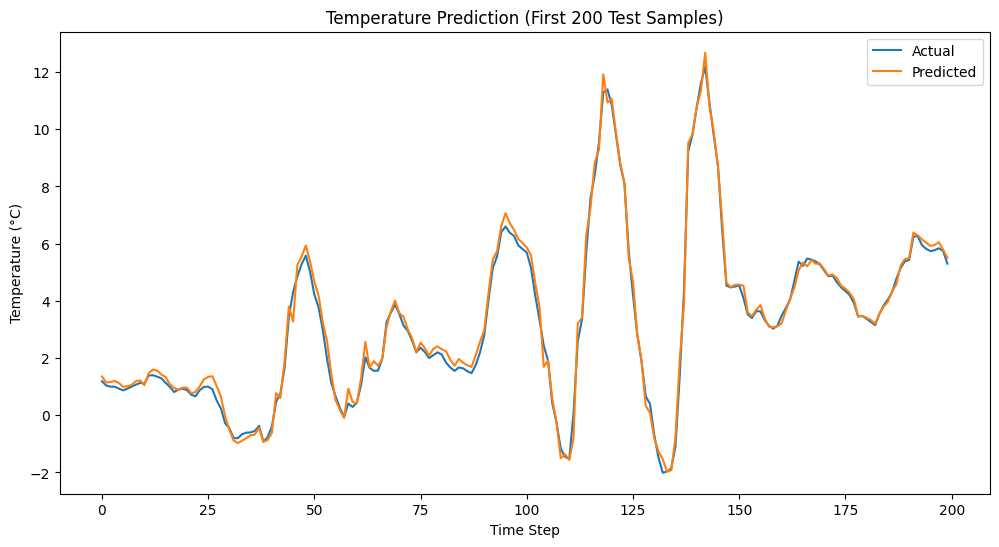

In [14]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test[:200], label="Actual")
plt.plot(y_pred[:200], label="Predicted")
plt.title("Temperature Prediction (First 200 Test Samples)")
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()